## Tensorflowで"Semi-supervised Clustering for Short Text via Deep Representation Learning"の実装¶
http://aclweb.org/anthology/K16-1004

In [4]:
import tensorflow as tf
import numpy as np
import sys
import random as rd
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
import MeCab
import subprocess
import itertools
import string
import sqlite3
from keras.preprocessing import sequence
rng = np.random.RandomState(1234)

Using TensorFlow backend.


# 1.データの準備

In [5]:
#
#ここで各ファイルのパスを設定します。
#

#学習に用いるデータ
dbpath = "../input/category_walkerplus.db"

#word2vecのモデル
model_path="../input/word2vec.gensim.model"

#辞書
dic_path="/usr/local/lib/mecab/dic/mecab-ipadic-neologd"

In [6]:
model = Word2Vec.load(model_path)
tagger = MeCab.Tagger("-Ochasen -d {0}".format(dic_path))

In [7]:
def cur(sourcedbname):
    con = sqlite3.connect(sourcedbname)
    cur = con.cursor()   
    sql = "select * from events"
    cur.execute(sql)
    return cur

In [8]:
Cur=cur(dbpath)

labels=[]
texts=[]
for row in Cur:
    labels.append(row[0].replace("[","").replace("]","").split(",")[1].replace(" ",""))  #Big Category
    texts.append(row[1])

## 分散表現の獲得
Data：入力の文章を分かち書きしw2vで埋め込み後padding shape=(データ数,maxlen,埋め込み次元)<br/>
Labels:正解ラベル

#### 分かち書き

In [9]:
def _tokenize(text):
    sentence = []
    node = tagger.parse(text)
    #print node
    node = node.split("\n")
    for i in range(len(node)):
        feature = node[i].split("\t")
        if feature[0] == "EOS":
            break
        hinshi = feature[3].split("-")[0]
        if "名詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "形容詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "動詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "形容動詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "連体詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])           
        elif "助詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
            
    return sentence

### 分散表現の獲得

In [10]:
def getVector(text):
    texts = _tokenize(text)
    v = []
    for t in texts:
        if t in model.wv:
            if v == []:
                v = model.wv[t]
            else:
                v = np.vstack((v,model.wv[t]))
    if v != []:
        return v
    else:
        return np.array([])

In [11]:
Data=np.array([getVector(text) for text in texts])

/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [12]:
Data = sequence.pad_sequences(Data, padding="post", truncating="post",dtype="float32")  #padding  

In [13]:
label2Label={name:i for i,name in enumerate(np.unique(labels))}  #label(名前)->Label(数字)
Labels=np.array([label2Label[label] for label in labels])  

# 2.教師データの選択

In [14]:
def load_data(Data,Labels,training_percent=0.9, supervise_percent=0.1):
    """
    Args:
        Data：入力の文章を分かち書きしw2vで埋め込み後padding shape=(データ数,maxlen,埋め込み次元)
        Labels:正解ラベル
        training_percent:trainingデータに使用する割合
        supervise_percent: supervise(教師データ)として一部与える割合(training_dataに対して)
    Returns:
        train_X:Dataの学習用
        train_y:Labelsの学習用
        test_X:Dataのテスト用
        test_y:Labelsのテスト用
        supervised:学習用データにおいて一部与える教師データのindex
    """
    #trainとtestでclassが均等になるようにsplit
    cluster_num=np.unique(Labels)
    train_index = []
    
    for i in range(len(cluster_num)):
        num = Labels[Labels==i].shape[0]
        k = int(num*training_percent)
        train_index.extend(rd.sample(list(np.where(Labels==i)[0]),k))
    
    #text classification for cnn のためにあらかじめlayerを追加
    train_X = Data[train_index][:,:,:,np.newaxis]
    train_y = Labels[train_index]
    test_X = np.delete(Data,train_index,0)[:,:,:,np.newaxis]
    test_y = np.delete(Labels,train_index,0)
    
    supervised = []

    for i in range(len(cluster_num)):
        num = train_y[train_y==i].shape[0]
        k = int(num*supervise_percent)
       
        supervised.extend(rd.sample(list(np.where(train_y==i)[0]),k))

    
    return train_X,train_y,test_X,test_y,supervised

In [15]:
train_X,train_y,test_X,test_y, supervised = load_data(Data,Labels)

## 3.CNN for Text Classificationの実装

### HyperParams

In [16]:
#窓の幅
filter_sizes = [3,5,7]
#分散表現の次元
vector_length = train_X.shape[2]
#最大系列長
sequence_length = train_X.shape[1]
#フィルターの枚数
num_filters = 16
#隠れ層
hid_dim=100
#出力次元数
output_dim=2
#クラスタリングするクラス多数
n_cluster=len(np.unique(train_y))

alpha=0.01
l=0

In [17]:
class Conv:
    def __init__(self, sequence_length,embedding_size,filter_sizes, num_filters):
        self.sequence_length=sequence_length
        self.embedding_size=embedding_size
        self.filter_sizes=filter_sizes
        self.num_filters=num_filters
    def f_prop(self,x):
        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(self.filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, self.embedding_size, 1, self.num_filters]
                
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]), name="b")
                conv = tf.nn.conv2d(
                    x,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, self.sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(self.filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        return self.h_pool_flat

class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier initializer
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function

    def f_prop(self, x):
        return self.function(tf.matmul(x, self.W) + self.b)
        
class LinearDense:
    def __init__(self, in_dim, out_dim):
        # Xavier initializer
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))

    def f_prop(self, x):
        return tf.matmul(x, self.W) + self.b

### グラフの構築

In [18]:
input_x = tf.placeholder(tf.float32, [None, sequence_length,vector_length,1], name="input_x")
input_t = tf.placeholder(tf.float32, [None, output_dim], name="input_y")

layers = [
    Conv(sequence_length=sequence_length,
         embedding_size=vector_length,
         filter_sizes=filter_sizes,
         num_filters=num_filters),
    Dense(num_filters * len(filter_sizes),hid_dim , tf.nn.tanh),
    LinearDense(hid_dim, output_dim)
]

def f_props(layers, x):
    for i, layer in enumerate(layers):
        x = layer.f_prop(x)
    return x

pred_y = f_props(layers, input_x)


### 誤差関数の設計
<img src='../img/jsemi.png'>

In [19]:
#目的関数の定義
def _cost(pred_y, centers, neighbor_index, sup_index, mask):
    """
    Args:
        pred_y: text-cnn の出力
        centers:各ラベルごとの重心 shape=(cluster_num, output_dim)
        neighbor_index:train_Xがどの重心に最も近いか shape=(data_num,)
        sup_index:教師データとして用いるtrain_Xの対応するクラスターID index shape=(sup_num,)
        mask:教師データとして用いるindexに1、それ以外に0が入ったmask
    """
    
    term1= tf.reduce_sum(tf.square(pred_y - tf.gather(centers, neighbor_index)))    
    term1_1 = alpha*tf.cast(term1, tf.float32)
    
    
    term2 = tf.reduce_sum(mask * tf.square(pred_y - tf.gather(centers, sup_index) ))
    term2_1 = (1-alpha)*tf.cast(term2, tf.float32)

    cost = tf.add(term1_1, term2_1)
    
    for i in range(n_cluster):
        i_index = i * tf.ones_like(sup_index, dtype='int32')
        
        x1 = tf.reduce_sum(tf.square(pred_y - tf.gather(centers, sup_index)),1)#正解の重心との距離
        x2 = tf.reduce_sum(tf.square(pred_y - tf.gather(centers, i_index)),1)     #i番目の重心との距離
                
        term2_2 = l+x1-x2
        
        condition = tf.greater(term2_2, 0)
        term2_3 = tf.reduce_sum(mask * tf.where(condition, term2_2, tf.zeros_like(term2_2)))
        term2_3 = tf.cast(term2_3, tf.float32)

        cost=tf.add(cost, (1-alpha)*term2_3)
        
    return cost

In [20]:
#  centers:各ラベルごとの重心 shape=(cluster_num, output_dim) 
centers= tf.placeholder(tf.float32, [None, output_dim], name="centers")

#  neighbor_index:train_Xがどの重心に最も近いか shape=(data_num,)
neighbor_index= tf.placeholder(tf.int32, [None], name="neighbor_index")

#  sup_index:教師データとして用いるtrain_Xの対応するクラスターID shape=(sup_num,)
sup_index=tf.placeholder(tf.int32, [None], name="supervised_index")

#  mask:教師データとして用いるindexに1、それ以外に0が入ったmask
mask=tf.placeholder(tf.float32, [None,1], name="mask")

#自作の誤差関数
cost = _cost(pred_y, centers, neighbor_index, sup_index, mask)

# 最小化にはAdamを用いる
train = tf.train.AdamOptimizer().minimize(cost)

# 4.Iteration
<img src='../img/iter.png'>

In [21]:
def assign_to_nearest(samples, centroids):
    """
    Args:
        samples:text-cnn後の出力
        centroids:クラスターそれぞれの重心 shape=(cluster_num,output_dim)
    Returns:
        nearest: 入力データと最も近いクラスターID shape=(data_num, )
    """
    #1-1.KNearest Neighborで一番近いクラスタと紐付け
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(centroids, np.arange(len(centroids)))
    nearest = neigh.predict(samples)
    
    #1-2.ハンガリアンアルゴリズムでラベル付きデータと重心を紐付ける
    
    sup_labels =train_y[supervised]
    hglabel = np.unique(sup_labels)
    
    hgx=[]  #教師データのラベルごとに平均した点（重心）を求める
    for i in hglabel:
        ind=np.where(sup_labels==i)[0]
        hgx.append(np.mean(samples[supervised][ind], axis=0))
    hgx = np.array(hgx)

    #教師ラベルごとの重心と現在の重心との距離行列
    DistanceMatrix = np.linalg.norm(hgx[:,np.newaxis,:]-centroids[np.newaxis,:,:],axis=2)  
    
    # ハンガリアンアルゴリズムで合計が一番小さくなるように紐づける 
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(DistanceMatrix)
    
    #ラベルとclusterIDを紐づける
    label2id={hglabel[i]:col for i,col in enumerate(col_ind)}
    
    
    return nearest ,label2id

In [22]:
def estimate_centroids(samples, nearest, label2id, use_supervised=True):
    """
    重心を再推定する
    重心の再推定式は簡略化してラベル付きと無しの加重平均
    Args:
        samples:text-cnn後の出力
        nearest: 入力データと最も近いクラスターID shape=(data_num, )
        label2id:labelとクラスターIDを紐づけるdict
        use_supervised:教師データを用いるかどうか（checkの際K-Meansが上手くいくか検証する際に用いいる）
    Returns:
        centroids:クラスターそれぞれの重心 shape=(cluster_num,output_dim)
        sup_cent:一部の教師データごとに現時点で対応するIDの重心が入った配列
    """
    sup_pred=samples[supervised]
    newce=np.array([label2id[t] for t in train_y[supervised]]) #現時点での一部の教師データと対応するクラスターIDの配列
            
    centroids=[]
    for i in range(n_cluster):
        sum1 = np.sum(alpha*len(np.where(nearest==i)[0]))
        sum2 = np.sum(alpha*samples[nearest==i], axis=0)
    
        if use_supervised:
            
            sum33 = np.sum((1-alpha)*len(np.where(newce==i)[0]))
            sum44 = np.sum((1-alpha)*sup_pred[newce==i], axis=0)
            
            centroids.append((sum2+sum44)/(sum1+sum33))
            
        else:
            centroids.append((sum2)/(sum1))
            
    centroids = np.array(centroids) 

    #3.NNのパラメータ更新
    sup_cent = np.array([centroids[c_id] for c_id in newce])
    
    return centroids, sup_cent



### 結果のPlot

In [64]:
def plot_clusters(all_samples, centroids, indices, save=False,save_name='output.png',iter_num=-1):
    
    import matplotlib.pyplot as plt
    #from sklearn.manifold import TSNE
    #all_samples= TSNE(n_components=2, random_state=0).fit_transform(all_samples)

    #Plot out the different clusters
    #Choose a different colour for each cluster
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    
    for i, centroid in enumerate(centroids):
        #Grab just the samples fpr the given cluster and plot them out with a new colour
        samples = all_samples[indices==i]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        #Also plot centroid
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=1)
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='m', mew=5)
        
        if iter_num>-1:
            plt.title('Iter : {}'.format(iter_num))
    
    if save:
        ims.append([line])
        plt.savefig( save_name )
    else:
        plt.show()
    plt.close()

# 5.学習

In [65]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
# 学習に関するHyperParams 
max_epochs=100

nb_epoch=1 #バッチ学習一周を何回行うか
batch_size = 32
n_batches = train_X.shape[0]//batch_size


#初期値獲得
samples=sess.run(pred_y, feed_dict={input_x:train_X})
centroids = np.array(rd.sample(list(samples),n_cluster))

#Mask
mask_array = np.zeros(len(train_X), dtype=int)
mask_array[supervised] = 1        
    

for iters in range(max_epochs):
    print("Epoch : ",iters)
    savename="../output/{0:03d}".format(iters)
    
    samples=sess.run(pred_y, feed_dict={input_x:train_X})
    
    nearest, label2id = assign_to_nearest(samples, centroids)

    centroids, sup_cent = estimate_centroids(samples, nearest, label2id, use_supervised=True)
    

    
    newce=np.array([label2id[t] for t in train_y])  #正解ラベル->対応するクラスターIDした配列    
    
    for _ in tqdm(range(nb_epoch)):
        shuffled_train_X,  shuffled_train_y, shuffled_nearest, shuffled_newce, shuffled_mask =shuffle(train_X,train_y, nearest, newce,mask_array)
       
        for i in range(n_batches):  
            start = i * batch_size
            end = start + batch_size

            batch_X = shuffled_train_X[start:end]
            batch_y = shuffled_train_y[start:end]
            batch_nearest = shuffled_nearest[start:end]
            batch_newce   = shuffled_newce[start:end]
            batch_mask     = shuffled_mask[start:end].reshape(-1,1)

            sess.run(train, feed_dict={input_x:batch_X, centers : centroids, neighbor_index:batch_nearest, sup_index:batch_newce, mask:batch_mask })
   
    
    plot_clusters(samples, centroids, train_y, save=True, save_name=savename, iter_num=iters)
    #収束を確認
    if iters>0:
        if np.all(nearest== prev_nearest):
                break
        else:
                from sklearn.metrics import accuracy_score
                prev_nearest = nearest
    else:
                prev_nearest = nearest

Epoch :  0


100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Epoch :  1


100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


Epoch :  2


100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


Epoch :  3


100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch :  4


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Epoch :  5


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Epoch :  6


100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Epoch :  7


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Epoch :  8


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Epoch :  9


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch :  10


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


Epoch :  11


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Epoch :  12


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


Epoch :  13


100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Epoch :  14


100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


Epoch :  15


100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


Epoch :  16


100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Epoch :  17


100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


Epoch :  18


100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch :  19


100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Epoch :  20


100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Epoch :  21


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Epoch :  22


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


Epoch :  23


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Epoch :  24


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Epoch :  25


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch :  26


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch :  27


100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Epoch :  28


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch :  29


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch :  30


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


Epoch :  31


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


Epoch :  32


100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


Epoch :  33


100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Epoch :  34


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


Epoch :  35


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Epoch :  36


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Epoch :  37


100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


Epoch :  38


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch :  39


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Epoch :  40


100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


Epoch :  41


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch :  42


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch :  43


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch :  44


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch :  45


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch :  46


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch :  47


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Epoch :  48


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch :  49


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch :  50


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch :  51


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch :  52


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch :  53


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch :  54


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch :  55


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch :  56


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch :  57


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch :  58


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch :  59


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch :  60


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch :  61


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch :  62


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch :  63


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch :  64


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch :  65


100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


Epoch :  66


100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


Epoch :  67


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Epoch :  68


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Epoch :  69


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Epoch :  70


100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Epoch :  71


100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


Epoch :  72


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Epoch :  73


100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


Epoch :  74


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


Epoch :  75


100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Epoch :  76


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


Epoch :  77


100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


Epoch :  78


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Epoch :  79


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Epoch :  80


100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


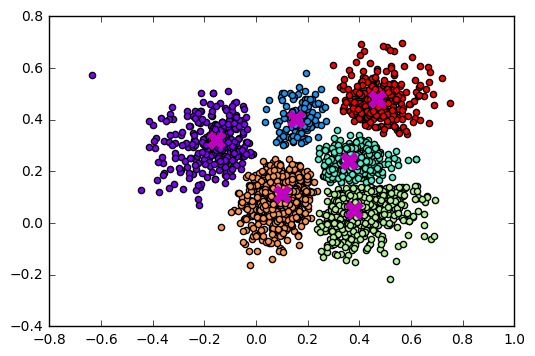

In [66]:
# クラスタリング結果(近傍ごとに色分け)
plot_clusters(samples, centroids, nearest)

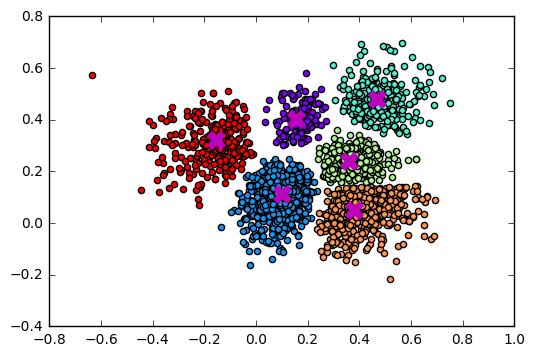

In [67]:
# クラスタリング結果（正解ラベルごとに色分け）
plot_clusters(samples, centroids,train_y)

## 正解率評価(近傍と写像後の対応するID)

In [68]:
print(accuracy_score(nearest, np.array([label2id[_] for _ in train_y])))

1.0


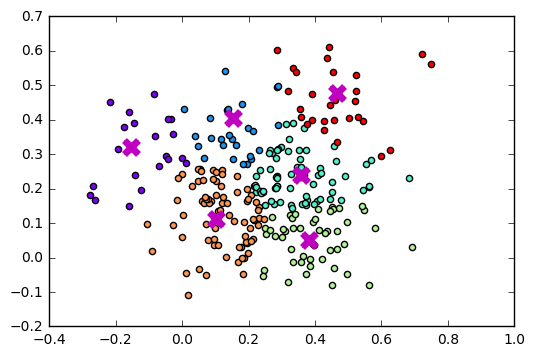

In [69]:
_samples=sess.run(pred_y, feed_dict={input_x:test_X})
    

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(centroids, np.arange(len(centroids)))
_nearest = neigh.predict(_samples)

# クラスタリング結果（正解ラベルごとに色分け）
plot_clusters(_samples, centroids, _nearest)

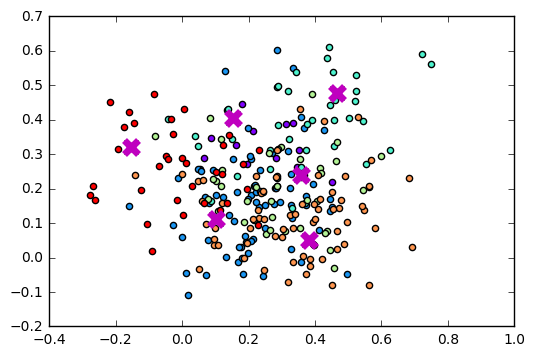

In [70]:
# クラスタリング結果（正解ラベルごとに色分け）
plot_clusters(_samples, centroids, test_y)

## GIFに書き出し

In [71]:
import subprocess

command='convert -layers optimize -loop 0 -delay 40 ../output/*.png ../img/out_main.gif'.split(" ")
res = subprocess.call(command)